In [1]:
#imports and data
import emcee
from multiprocessing import Pool
from multiprocessing import cpu_count
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
from PyAstronomy.pyasl import binningx0dt
from scipy import optimize # scipy-1.1.0
import matplotlib.pyplot as plt
%matplotlib inline

# import RV data
path = './KH15D_data_modified.txt'
data = pd.read_csv(path, delim_whitespace=True)
data['mnvel']*=1000 # convert km/s to m/s
data['errvel']*=1000

t_start = min(data['time'].values)
t_stop = max(data['time'].values)
ti = np.linspace(t_start,t_stop,10000)

RV = data['mnvel']
e_RV = data['errvel']
time_RV = data['time']

# import photometry data
data_new = pd.read_csv('kh15d_2020_data.txt',delim_whitespace=True)
data_new = data_new.drop(data_new[data_new.e_Imag == 9.999].index)
data2 = pd.read_csv('johnson_data.txt', delim_whitespace=True)
data3 = pd.read_csv('maffei_data_new.txt', delim_whitespace=True)

print('Data points before binning:', len(data_new)+len(data2)+len(data3))

ccd_binned, dt = binningx0dt(data_new['date'], data_new['Imag'], yerr=data_new['e_Imag'], x0=data_new['Imag'][0], dt= 0.6401, useBinCenter=True)

JD = np.concatenate((np.array([data3['JD']][0]), np.array([data2['JD']][0]), ccd_binned[:,0]))
Imag = np.concatenate((np.array([data3['Imag']][0]), np.array([data2['Imag']][0]), ccd_binned[:,1]))
e_Imag = np.concatenate((np.array([data3['e_Imag']][0]), np.array([data2['e_Imag']][0]), ccd_binned[:,2]))
e_Imag = np.sqrt(e_Imag**2+(0.1*2.5/np.log(10))**2)

print('After binning:', len(JD))

Data points before binning: 6421
After binning: 2813


In [2]:
# KH 15D parameters
m_A, m_B = 0.6*2e30, 0.72*2e30
R_A, R_B = 1.3*6.96e8, 1.365*6.96e8 
G = 6.6741e-11
u = 0.65

def photometric_model(Imag, e_Imag, LB, L0, L0_dot, L0_ddot, epsilon1, 
                    epsilon2, Xi_1, Xi_2, t3, t6, thetaL1_dot, thetaL2_dot, thetaT_dot, theta_ddot, thetaL_t3, thetaT_t3, YL_dot,YT_dot, 
                    YL_t0, YT_t0, P, Tp, e, w, I, E, E_full, greg_date, greg_date_full):
    
    I0 = (1-epsilon1*(1+2/Xi_1)-epsilon2)/(np.pi*(1-u/3))
    epsilon_star = I0*np.pi*(1-u/3)
    a = np.cbrt((P*86400)**2*G*(m_A+m_B)/(4*np.pi**2))
    
    def edge(x, t, theta, Y_t0, Y_dot):  
        return np.tan(theta)*x + (Y_t0 + Y_dot*t)

    def leading_flux_edge(v):
        F = 0
        if v < -1:
            F = epsilon1*(1+2/Xi_1-np.exp((v+1)/Xi_1)) + epsilon_star + epsilon2
        if v > -1 and v < 1:
            F = epsilon2 + epsilon_star/2 - I0*((1-u)*(v*np.sqrt(1-v**2)+np.arcsin(v))+np.pi/2*u*v*(1-v**2/3))+epsilon1*(1-v)/Xi_1
        if v > 1:
            F = epsilon2*np.exp(-(v-1)/Xi_2)
        return F

    def tail_flux_edge(v):
        F = 0
        if v < -1:
            F = epsilon1*(np.exp((v+1)/Xi_1))
        if v > -1 and v < 1:
            F = epsilon1*(1+(v+1)/Xi_1) + I0*((1-u)*(v*np.sqrt(1-v**2)+np.arcsin(v))+np.pi/2*u*v*(1-v**2/3))+epsilon_star/2
        if v > 1:
            F = epsilon1*(1+2/Xi_1) + epsilon_star + epsilon2*(1-np.exp(-(v-1)/Xi_2))
        return F

    def calculate_light_curve(E, greg_date, Imag, Imag_err, I_ref=0):
  
        x_b, y_b = a*(np.cos(E)-e), a*np.sqrt(1-e**2)*np.sin(E)
        r_x = -np.sin(w)*y_b + np.cos(w)*x_b
        r_y = np.sin(w)*(x_b*np.cos(I)) + np.cos(w)*(y_b*np.cos(I))
        x_A, y_A = solve_position('a', r_x, r_y, m_A, m_B)
        x_B, y_B = solve_position('b', r_x, r_y, m_A, m_B)

        light_curve, flux_curve, light_curve_A, light_curve_B = np.zeros(len(greg_date)), np.zeros(len(greg_date)), np.zeros(len(greg_date)), np.zeros(len(greg_date))
                        
        for i, value in enumerate(light_curve):
                                    
            if greg_date[i] < t3:
                thetaL = thetaL_t3 + thetaL1_dot*(greg_date[i]-t3) 
            if greg_date[i] > t3:
                thetaL = thetaL_t3 + thetaL2_dot*(greg_date[i]-t3)  
                
            thetaT = thetaT_t3 + thetaT_dot*(greg_date[i]-t3) 
            
            Y_L = edge(0, greg_date[i], thetaL, YL_t0, YL_dot) 
            Y_T = edge(0, greg_date[i], thetaT, YT_t0, YT_dot)
            
            vA_L = -1/R_A*(np.sin(-thetaL)*x_A[i] + np.cos(-thetaL)*(y_A[i] - Y_L))
            vB_L = -1/R_B*(np.sin(-thetaL)*x_B[i] + np.cos(-thetaL)*(y_B[i] - Y_L))

            vA_T = -1/R_A*(np.sin(-thetaT)*x_A[i] + np.cos(-thetaT)*(y_A[i] - Y_T))
            vB_T = -1/R_B*(np.sin(-thetaT)*x_B[i] + np.cos(-thetaT)*(y_B[i] - Y_T))

            light_curve_A[i] = (leading_flux_edge(vA_L)+tail_flux_edge(vA_T)) 
            light_curve_B[i] = (leading_flux_edge(vB_L)+tail_flux_edge(vB_T))
            
            flux_curve[i] = light_curve_A[i] + LB*light_curve_B[i]
            light_curve[i] = - 2.5*np.log10(flux_curve[i])
                 
        if len(light_curve) != len(greg_date_full):    
            I_ref = np.sum((Imag - light_curve)/Imag_err**2)/np.sum(1/Imag_err**2)
            #print(I_ref)
            return I_ref, light_curve + I_ref, flux_curve
        
        return light_curve + I_ref, flux_curve

    I_ref, magModel, fluxModel = calculate_light_curve(E, greg_date, Imag, e_Imag)
    magModel_full, fluxModel_full = calculate_light_curve(E_full, greg_date_full, Imag, e_Imag, I_ref)
    
    return I_ref, magModel, magModel_full, fluxModel, fluxModel_full

def solve_position(star, x, y, m_A, m_B):
    if star == 'a':
        return -(m_A/m_B + 1)**-1*x, -(m_A/m_B + 1)**-1*y
    if star == 'b':
        return (m_B/m_A + 1)**-1*x, (m_B/m_A + 1)**-1*y
    
def calculate_edge(t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot, a, w, I, E_edge, m_A, m_B):

        thetaL_t5 = thetaL_t3 + thetaL2_dot*(t5-t3) 
        thetaT_t6 = thetaT_t3 + thetaT_dot*(t6-t3)
        
        x_b, y_b = a*(np.cos(E_edge)-e), a*np.sqrt(1-e**2)*np.sin(E_edge)
        r_x = -np.sin(w)*y_b + np.cos(w)*x_b
        r_y = np.sin(w)*(x_b*np.cos(I)) + np.cos(w)*(y_b*np.cos(I))
        x_A, y_A = solve_position('a', r_x, r_y, m_A, m_B)
        x_B, y_B = solve_position('b', r_x, r_y, m_A, m_B)
        
        E_shift = np.arctan(-np.tan(w)*np.sqrt(1-e**2))

        def derivative_t5(E):
            #differentiated wrt E
            x_b = -a*np.sin(E)
            y_b = a*np.sqrt(1-e**2)*np.cos(E)
            r_x = -np.sin(w)*y_b + np.cos(w)*x_b
            r_y = np.sin(w)*(x_b*np.cos(I)) + np.cos(w)*(y_b*np.cos(I))

            return (r_y/r_x - np.tan(thetaL_t5))
        
        def derivative_t6(E):
            #differentiated wrt E
            x_b = -a*np.sin(E)
            y_b = a*np.sqrt(1-e**2)*np.cos(E)
            r_x = -np.sin(w)*y_b + np.cos(w)*x_b
            r_y = np.sin(w)*(x_b*np.cos(I)) + np.cos(w)*(y_b*np.cos(I))

            return (r_y/r_x - np.tan(thetaT_t6))
        
        # Note orbits start at -pi at the argument of periapsis (w), which happens at the time of periasis (Tp)
        t5_root = optimize.brentq(derivative_t5, E_shift + 0.000001, np.pi + E_shift - 0.000001)
        t6_root = optimize.brentq(derivative_t6, E_shift + 0.000001, np.pi + E_shift - 0.000001)

        def E_to_position(E):
            x_b = a*(np.cos(E)-e)
            y_b = a*np.sqrt(1-e**2)*np.sin(E)
            x = -np.sin(w)*y_b + np.cos(w)*x_b
            y = np.sin(w)*(x_b*np.cos(I)) + np.cos(w)*(y_b*np.cos(I))
            return x, y
      
        # solve for projected position (x, y) of star intersecting the lead/tail edge 
        x_t5, y_t5 = E_to_position(t5_root)
        x_t6, y_t6 = E_to_position(t6_root)
        x_t5, y_t5 = solve_position('a', x_t5, y_t5, m_A, m_B)
        x_t6, y_t6 = solve_position('b', x_t6, y_t6, m_A, m_B)
        
        # solve for y-intercept of lead/tail edge at a given time
        YL_t5 = y_t5-np.tan(thetaL_t5)*x_t5
        YT_t6 = y_t6-np.tan(thetaT_t6)*x_t6

        # solve for the change in y-intercept of lead/tail edge
        YL_dot = (YL_t5-0.)/(t5-t3)
        YT_dot = alpha*YL_dot
        
        YL_t6 = 0. + (t6-t3)*YL_dot
        YT_t3 = YT_t6 - (t6-t3)*YT_dot
        
        # solve for the y-intercept of lead/tail edge at t=t0
        YL_t0 = YL_t5-YL_dot*t5  # using t3 or t5 give the same value
        YT_t0 = YT_t6-YT_dot*t6 

        return YL_dot, YT_dot, YL_t0, YT_t0

def pre_photometric_model(JD, date_full, Imag, Imag_err, LB, L0, L0_dot, L0_ddot, epsilon1, 
                      epsilon2, Xi_1, Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot, theta_ddot, P, Tp, e, w, I):
    
    w, I, thetaL_t3, thetaT_t3 = w*(np.pi/180), I*(np.pi/180), thetaL_t3*(np.pi/180), thetaT_t3*(np.pi/180)
    a = np.cbrt((P*86400)**2*G*(m_A+m_B)/(4*np.pi**2))
    greg_date_full = (date_full - 2451545.0)/365.25 + 2000 #JD 2451545 is year 2000
    greg_date = (JD - 2451545.0)/365.25 + 2000 #JD 2451545 is year 2000
    
    def solveE(M): # Kepler's eqn. for eccentric orbits
        f_list = [] 
        for M_index in range(len(M)):    
            f_list.append(lambda E:E - e*np.sin(E) - M[M_index])
        E = np.zeros(len(M))
        for M_index in range(len(M)):    
            E[M_index] = optimize.brentq(f_list[M_index], -5000, 5000)
        return E    

    E_edge = solveE(np.linspace(-np.pi, 3*np.pi, 1000)) # for occulting edge
    E = solveE((2*np.pi/P)*(JD - Tp)) # for each data point
    E_full = solveE((2*np.pi/P)*(date_full - Tp)) # for full light curve
    
    YL_dot, YT_dot, YL_t0, YT_t0 = calculate_edge(t3, 
                    t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot, a, w, I, E_edge, m_A, m_B)
    
    return thetaL_t3, thetaT_t3, YL_dot, YT_dot, YL_t0, YT_t0, E, E_full, greg_date, greg_date_full, w, I

def plot_photometry(JD, date_full, Imag, Imag_err, LB, L0, L0_dot, L0_ddot, epsilon1, 
                      epsilon2, Xi_1, Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot, theta_ddot, P, Tp, e, w, I):
 
    thetaL_t3, thetaT_t3, YL_dot, YT_dot, YL_t0, YT_t0, E, E_full, greg_date, greg_date_full, w, I = pre_photometric_model(JD, date_full, Imag, Imag_err, LB, L0, L0_dot, L0_ddot, epsilon1, 
                      epsilon2, Xi_1, Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot, theta_ddot, P, Tp, e, w, I)
    
    return photometric_model(Imag, e_Imag, LB, L0, L0_dot, L0_ddot, epsilon1, 
                    epsilon2, Xi_1, Xi_2, t3, t6, thetaL1_dot, thetaL2_dot, thetaT_dot, theta_ddot, thetaL_t3, thetaT_t3, YL_dot,YT_dot, 
                    YL_t0, YT_t0, P, Tp, e, w, I, E, E_full, greg_date, greg_date_full)

def solveE(M): # Kepler's eqn. for eccentric orbits
        f_list = [] 
        for M_index in range(len(M)):    
            f_list.append(lambda E:E - e*np.sin(E) - M[M_index])
        E = np.zeros(len(M))
        for M_index in range(len(M)):    
            E[M_index] = optimize.brentq(f_list[M_index], -5000, 5000)
        return E    

def plot_folded(ax, year1,year2,Imag_model):

    index1 = np.argmin(np.abs(greg_date-year1))
    index2 = np.argmin(np.abs(greg_date-year2))
    indexfull1 = np.argmin(np.abs(greg_date_full-year1))
    indexfull2 = np.argmin(np.abs(greg_date_full-year2))

    x,y = (E_full[indexfull1:indexfull2+1]/(2*np.pi)+0.5)%1, Imag_model[indexfull1:indexfull2+1]
    xdata,ydata,yerr = (E[index1:index2+1]/(2*np.pi)+0.5)%1, Imag[index1:index2+1],e_Imag[index1:index2+1]

    indexM = []
    for i in range(len(x)):
        if i>0 and x[i]<x[i-1]: # decreasing means max index
            indexM.append(i)
    indexM = np.array(indexM)   
    
    plt.xticks([0.2,0.5,0.8])
    plt.yticks([18,16,14])
    
    for i in range(len(indexM)):
        if i == 0:
            ax.plot(x[0:indexM[0]], y[0:indexM[0]], lw=0.5, c='black', zorder=1)    
        elif i < len(indexM)-1:
            ax.plot(x[indexM[i]:indexM[i+1]], y[indexM[i]:indexM[i+1]], lw=0.5, c='black', zorder=1)

    if year2 < 2020.:
        ax.errorbar(xdata, ydata, yerr=yerr, ms = 1.5, elinewidth=1., fmt='--o', c='blue', ls='None', zorder=2)
    ax.invert_yaxis()
    ax.set_xticks([0.2,0.4,0.6,0.8])
    ax.set_yticks([14, 15, 16, 17, 18])
    ax.set_ylim([19, 13])
    ax.set_xlim([0, 1])
    ax.set_xlabel('Phase')
    ax.set_ylabel('I [mag]')
    
def calculate_photometric_chi2(JD, date_full, Imag, Imag_err, LB, L0, L0_dot, L0_ddot, epsilon1, 
                      epsilon2, Xi_1, Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot, theta_ddot, P, Tp, e, w, I):
    
    thetaL_t3, thetaT_t3, YL_dot, YT_dot, YL_t0, YT_t0, E, E_full, greg_date, greg_date_full, w, I = pre_photometric_model(JD, date_full, Imag, Imag_err, LB, L0, L0_dot, L0_ddot, epsilon1, 
                      epsilon2, Xi_1, Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot, theta_ddot, P, Tp, e, w, I)
                                                
    I_ref, magModel, magModel_full, fluxModel, fluxModel_full = photometric_model(Imag, e_Imag, LB, L0, L0_dot, L0_ddot, epsilon1, 
                    epsilon2, Xi_1, Xi_2, t3, t6, thetaL1_dot, thetaL2_dot, thetaT_dot, theta_ddot, thetaL_t3, thetaT_t3, YL_dot, YT_dot, 
                    YL_t0, YT_t0, P, Tp, e, w, I, E, E_full, greg_date, greg_date_full)

    chi2_flux = np.zeros(len(JD))
    chi2_mag = np.zeros(len(JD))
    
    for i in range(len(JD)):
        rel_flux = 100**((I_ref - Imag[i])/5)
        rel_flux_model = 100**((I_ref - magModel[i])/5)
        rel_flux_error = Imag_err[i]*rel_flux*np.log(10)/2.5
        rel_flux_error = np.sqrt(rel_flux_error**2 + (0.1*rel_flux)**2)
        
        chi2_flux[i] = (rel_flux - rel_flux_model)**2/rel_flux_error**2
        chi2_mag[i] = (Imag[i] - magModel[i])**2/Imag_err[i]**2

    total_chi2 = np.sum(chi2_mag)

    return total_chi2, chi2_mag

In [3]:
# Optimal parameters following Table 2
optimal_values = np.array([ 4.83776596e+01,  2.45235418e+06,  5.78367747e-01,  1.18026056e+01,
  9.10013920e+01,  1.65394863e+00,  4.35520082e-02,  5.91361906e-02,
  1.52947111e+00,  2.85789726e+00,  1.99268129e+03,  2.00795202e+03,
  2.01357165e+03, -1.59649619e+01, -5.27843668e+00,  7.65528264e-03,
  3.28881258e-03, -5.79936313e-04])
P, Tp, e, w, I, LB, epsilon1, epsilon2, Xi_1, Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot = optimal_values

# Old parameters
L0 = 0.0
L0_dot = 0.0
L0_ddot = 0.0
theta_ddot = 0.0

# From Sec. 2.3: Prescribe the rate of ascent of the trailing edge in relation to the 
# rate of ascent of the leading edge. Specifically, we take Ydot_Trailing = alpha * Ydot_Leading...
alpha = 0.5 

In [4]:
# Setup for full light curve
date_full = np.linspace(2435000,2465000,100000)
greg_date_full = (date_full - 2451545.0)/365.25 + 2000 #JD 2451545 is year 2000
greg_date = (JD - 2451545.0)/365.25 + 2000 #JD 2451545 is year 2000
E = solveE((2*np.pi/P)*(JD - Tp)) # for each data point
E_full = solveE((2*np.pi/P)*(date_full - Tp)) # for full light curve

photometric_chi2, chi2_list = calculate_photometric_chi2(JD, date_full, Imag, e_Imag, LB, L0, L0_dot, L0_ddot, epsilon1,
    epsilon2, Xi_1, Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot, theta_ddot, P, Tp, e, w, I)
#print(photometric_chi2)

I_ref, magModel, magModel_full, fluxModel, fluxModel_full = plot_photometry(JD, date_full, Imag, e_Imag, LB, L0, L0_dot, L0_ddot, epsilon1, 
                      epsilon2, Xi_1, Xi_2, t3, t5, t6, thetaL_t3, thetaT_t3, thetaL1_dot, thetaL2_dot, thetaT_dot, theta_ddot, P, Tp, e, w, I)

Imag_model = magModel_full
flux_curve = fluxModel_full

/tmp/ipykernel_1189/3488177206.py:226: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--o" (-> linestyle='--'). The keyword argument will take precedence.
  ax.errorbar(xdata, ydata, yerr=yerr, ms = 1.5, elinewidth=1., fmt='--o', c='blue', ls='None', zorder=2)
/tmp/ipykernel_1189/3488177206.py:226: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--o" (-> linestyle='--'). The keyword argument will take precedence.
  ax.errorbar(xdata, ydata, yerr=yerr, ms = 1.5, elinewidth=1., fmt='--o', c='blue', ls='None', zorder=2)
/tmp/ipykernel_1189/3488177206.py:226: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--o" (-> linestyle='--'). The keyword argument will take precedence.
  ax.errorbar(xdata, ydata, yerr=yerr, ms = 1.5, elinewidth=1., fmt='--o', c='blue', ls='None', zorder=2)
/tmp/ipykernel_1189/3488177206.py:226: UserWarning: 

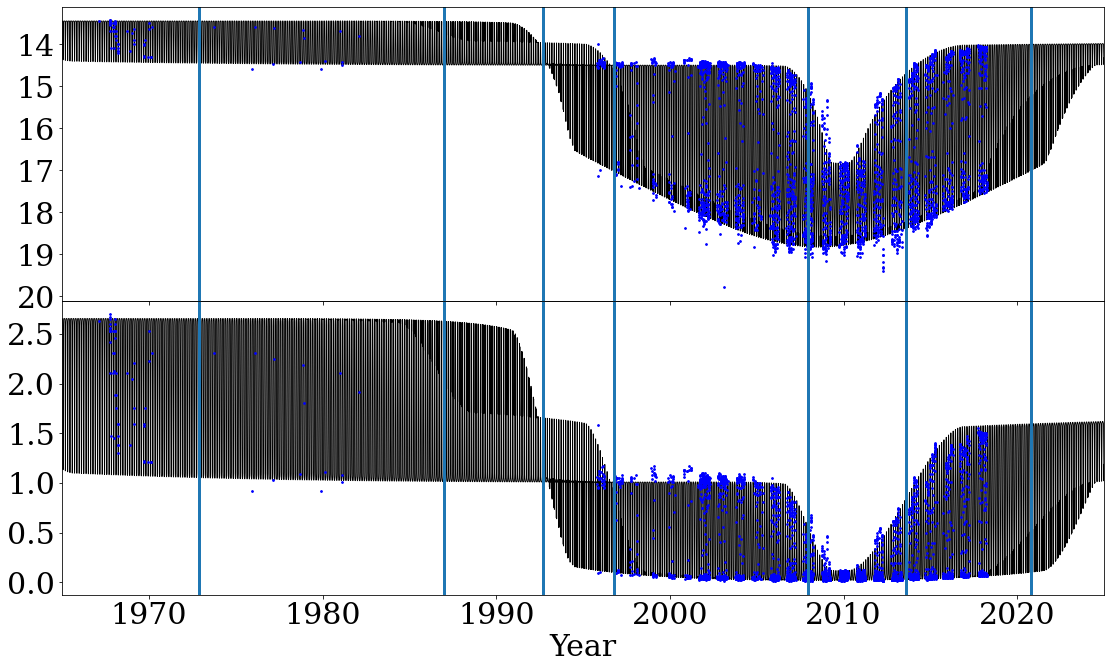

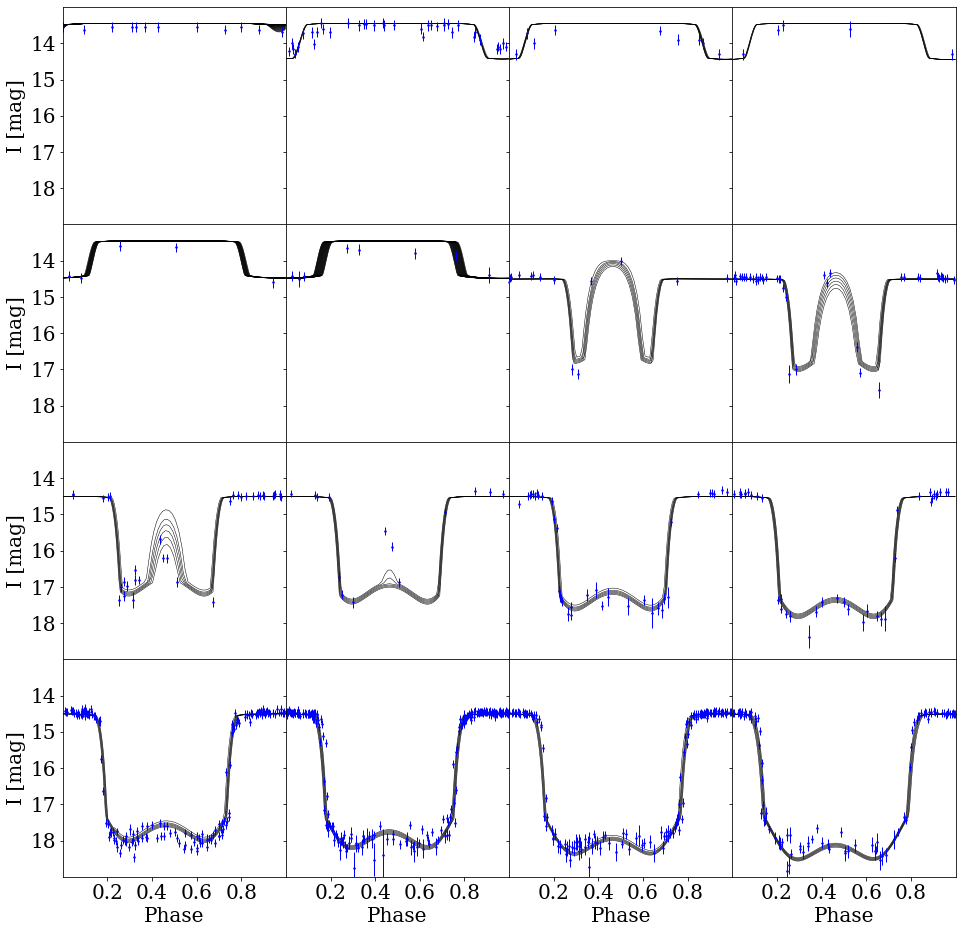

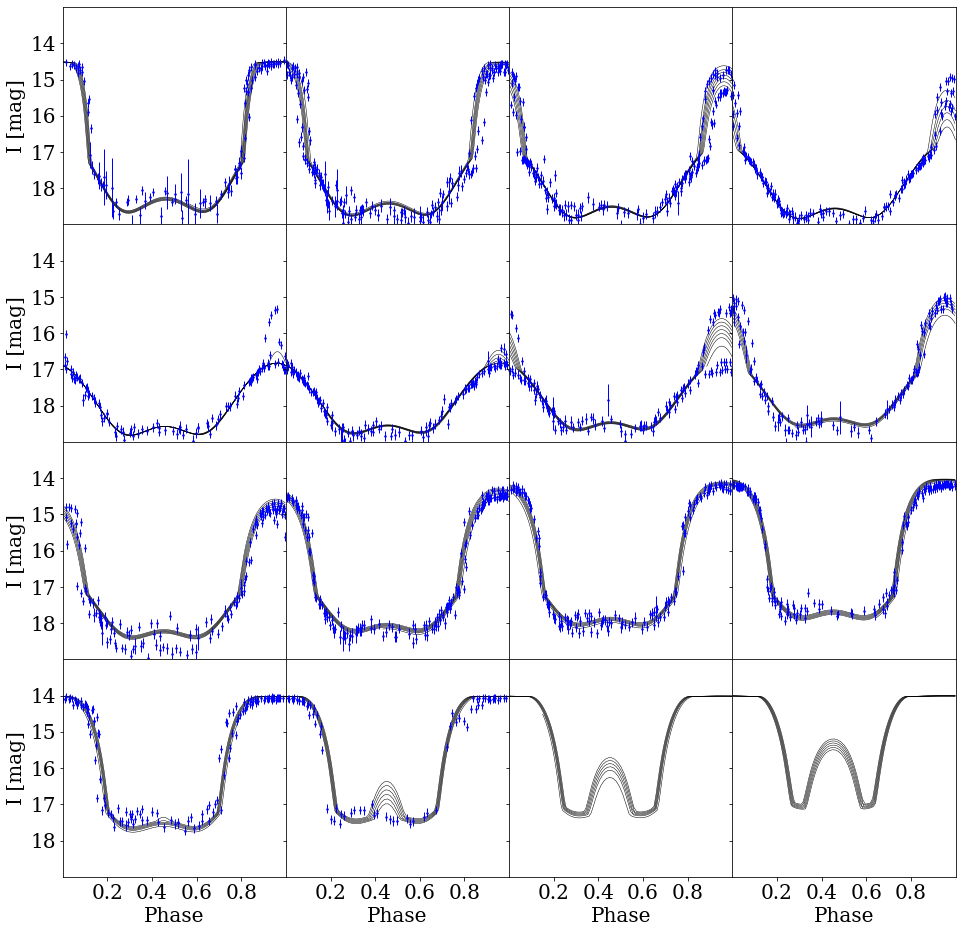

In [5]:
# plots

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 30})

t1 = 1972.9
t2 = 1987.00
t3 = 1992.68
t4 = 1996.8
t5 = 2007.95
t6 = 2013.57
t7 = 2020.8

fig, ax1 = plt.subplots(2, sharex=True,gridspec_kw={'hspace':0},figsize=(16,10))

ax1[0].plot(greg_date_full, Imag_model, lw=0.9, c='black', zorder=1)
ax1[0].scatter(greg_date, Imag, s=3, c='blue', zorder=2)
ax1[0].patch.set_alpha(0.0)
ax1[0].set_xlim([1965, 2025])
ax1[0].invert_yaxis()
fig.tight_layout()
ax1[0].axvline(t1, lw=3)
ax1[0].axvline(t2, lw=3)
ax1[0].axvline(t3, lw=3)
ax1[0].axvline(t4, lw=3)
ax1[0].axvline(t5, lw=3)
ax1[0].axvline(t6, lw=3)
ax1[0].axvline(t7, lw=3)

ax1[1].set_xlabel('Year')
ax1[1].plot(greg_date_full, flux_curve, lw=0.9, c='black', zorder=1)
ax1[1].scatter(greg_date, 10**(0.4*(14.508-Imag)), s=3, c='blue', zorder=2)
ax1[1].patch.set_alpha(0.0)
ax1[1].set_xlim([1965, 2025])
ax1[1].axvline(t1, lw=3)
ax1[1].axvline(t2, lw=3)
ax1[1].axvline(t3, lw=3)
ax1[1].axvline(t4, lw=3)
ax1[1].axvline(t5, lw=3)
ax1[1].axvline(t6, lw=3)
ax1[1].axvline(t7, lw=3)
fig.tight_layout()

#plt.savefig('flux1.png', dpi=250)

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

plt.rcParams.update({'font.size': 20})

fig, axs = plt.subplots(4, 4, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0},figsize=(16,16))
(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16) = axs

plot_folded(ax1, 1956.0,1960.0,Imag_model)
plot_folded(ax2, 1968.0,1969.0,Imag_model)
plot_folded(ax3, 1969.0,1970.0,Imag_model)
plot_folded(ax4, 1970.0,1971.0,Imag_model)
plot_folded(ax5, 1975.0,1978.0,Imag_model)
plot_folded(ax6, 1978.0,1983.0,Imag_model)
plot_folded(ax7, 1995.0,1996.0,Imag_model)
plot_folded(ax8, 1996.0,1997.0,Imag_model)
plot_folded(ax9, 1997.0,1998.0,Imag_model)
plot_folded(ax10, 1998.0,1999.0,Imag_model)
plot_folded(ax11, 1999.0,2000.0,Imag_model)
plot_folded(ax12, 2000.0,2001.0,Imag_model)
plot_folded(ax13, 2001.0,2002.0,Imag_model)
plot_folded(ax14, 2002.0,2003.0,Imag_model)
plot_folded(ax15, 2003.0,2004.0,Imag_model)
plot_folded(ax16, 2004.0,2005.0,Imag_model)

for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('folded1.png', dpi=300)

fig, axs = plt.subplots(4, 4, sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0, 'wspace': 0},figsize=(16,16))
(ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16) = axs
    
plot_folded(ax1,2005.0,2006.0,Imag_model)
plot_folded(ax2,2006.0,2007.0,Imag_model)
plot_folded(ax3,2007.0,2008.0,Imag_model)
plot_folded(ax4,2008.0,2009.0,Imag_model)
plot_folded(ax5,2009.0,2010.0,Imag_model)
plot_folded(ax6,2010.0,2011.0,Imag_model)
plot_folded(ax7,2011.0,2012.0,Imag_model)
plot_folded(ax8,2012.0,2013.0,Imag_model)
plot_folded(ax9,2013.0,2014.0,Imag_model)
plot_folded(ax10,2014.0,2015.0,Imag_model)
plot_folded(ax11,2015.0,2016.0,Imag_model)
plot_folded(ax12,2016.0,2017.0,Imag_model)
plot_folded(ax13,2017.0,2018.0,Imag_model)

plot_folded(ax14,2018.0,2019.0,Imag_model)
plot_folded(ax15,2019.0,2020.0,Imag_model)
plot_folded(ax16,2020.0,2021.0,Imag_model)

for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('folded2.png', dpi=300)